In [1]:
from ultralytics import YOLO
import torch
import torchvision
from torch import nn
# import torchsummary as summary
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import glob

In [2]:
torch.tensor(0.)

tensor(0.)

In [3]:
def imshow_image(img):
    num = len(img)
    print(num)
    if num == 1:
        img = img[0]
        if len(img.shape) == 3:
            img = img.unsqueeze(0)
        img = img[:,:3,:,:]
        img = img.permute(0,2,3,1).cpu()[0]
        img = img.detach().numpy()
        plt.imshow(img)
        plt.show()
    else:
        fig, ax = plt.subplots(1, num)
        for i, im in enumerate(img):
            if len(im.shape) == 3:
                im = im.unsqueeze(0)
            im = im[:,:3,:,:]
            im = im.permute(0,2,3,1).cpu()[0]
            im = im.detach().numpy()
            ax[i].imshow(im)

def plot_loss(losses):
    losses_plot = [i.cpu().detach().numpy() for i in losses]
    plt.plot(losses_plot)

def imshow_np_image(img):
    plt.imshow(img[:,:,::-1])    
    plt.show()


In [4]:
yolo = YOLO('best.pt')
# yolo = YOLO('pretrained\yolov8s\\pbest.pt')
# yolo = YOLO('pretrained/mask3e.pt')

In [5]:
info_label = {
    'age': ['20-30s', '40-50s', 'Baby', 'Kid', 'Senior', 'Teenager'],
    'race': ['Caucasian', 'Mongoloid', 'Negroid'],
    'masked': ['masked', 'unmasked'],
    'skintone': ['dark', 'light', 'mid-dark', 'mid-light'],
    'emotion': ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise'],
    'gender': ['Female', 'Male']
}

In [6]:
def process_out_detect(img, results):
    bbox_lis = []
    for r in results:
        boxes = r.boxes
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            bbox_lis.append([x1, y1, x2, y2])

            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 3)
            cv2.putText(img, str(i+1) ,(x1,y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 1)
        return bbox_lis

def sample_values(lis):
    print(lis)
    lis = list(lis)
    while len(lis) < 30:
        lis.append(-1)
    return lis

def convert_to_text(key, index):
    return info_label[key][index]






0: 224x320 1 face, 72.8ms
Speed: 3.0ms preprocess, 72.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 320)


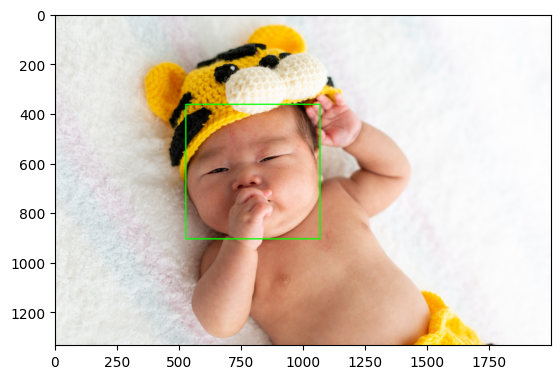

tensor([[0.4284, 0.5661, 0.0055]], device='cuda:0')
1 {'age': '20-30s', 'race': 'Mongoloid', 'masked': 'unmasked', 'skintone': 'light', 'emotion': 'Neutral', 'gender': 'Female'}



In [10]:
def get_index_label(bbox, label_bbox):
    x1, y1, x2, y2 = bbox
    
    pred_center = [(x1+x2)//2, (y1+y2)//2]
    distance_lis = []
    for lbbox in list(label_bbox.values):
        lbbox = lbbox[1:-1].split(', ')
        lbbox = [int(i) for i in lbbox]
        x, y, w, h = lbbox
        label_center = [(x+x+w)//2, (y+y+h)//2]
        distance_lis.append([abs(pred_center[i] - label_center[i]) for i in range(len(label_center))])
    distance_lis = np.array(distance_lis)
    distance_lis = np.sum(distance_lis, axis= 1)
    index_label = np.argmin(distance_lis)
    return index_label

def get_label(df, name, bbox):
    name = name.replace("\\", "/")
    a = df[df['file_name'] == name]
    labels = {}

    i = get_index_label(bbox, a['bbox'])

    attr = 'age,race,masked,skintone,emotion,gender'.split(',')
    for key in attr:
        labels[key] = convert_to_text(key, a.iloc[i][key])
        
    return labels

def procees_out_cls(results, index_box):
    preds = {}
    num_cate = iter([6,3,2,4,7,2])
    for key in results.keys():
        cur_cate = next(num_cate)
        pred = results[key]
        # print(pred)
        pred = pred[:, (index_box * cur_cate):((index_box + 1) * cur_cate)]
        pred = torch.softmax(pred, dim= -1)
        if key == 'race':
            print(pred)
        pred = torch.argmax(pred, dim= -1)
        index = int(pred.cpu().detach().numpy())
        preds[key] = convert_to_text(key, index)
    return preds

df = pd.read_csv("D:/Pixta/ultralytics_custom5/encode_csvfile/encoded_black_labels.csv")
# path = 'D:/Pixta/mnt/md0/projects/sami-hackathon/private/data/images/'
path = 'public_test/'
# path = 'private_test/images/'
# path = 'D:/Pixta/black_data/images/'

names = os.listdir(path)
np.random.shuffle(names)
preds = []
labels = []
for name in names[:1]:
    # name = 'cr_1329.jpg'
    # img_root = cv2.imread(name)
    img_root = cv2.imread(path + name)
    # img_root = cv2.resize(img_root, (320,320))
    img = img_root.copy()

    results = yolo(img_root, stream= False)
    bbox_lis = process_out_detect(img, results[0])
    imshow_np_image(img)

    for i in range(len(bbox_lis)):
        preds_cls = procees_out_cls(results[1], i)

        # labels_dict = get_label(df, name, bbox_lis[i])
        print(i+1, preds_cls)
        # print(labels_dict)
        print()